## $T_2$ Dephasing with Markovian Noise

The opposite of (fully correlated) quasi-static noise is white
noise. In this case, the noise traces are uncorrelated in time and hence,
Markovian. Instead of performing Monte Carlo simulations to find the average
evolution, we can effectively describe the effect of Markoian noise using the
Lindblad master equation.

As an example, we investigate again resonant driving with the Hamiltonian

\begin{align}
H = \frac{\omega - \omega_0}{2} \sigma_z
+ \frac{u_x}{2} \sigma_x + \frac{u_y}{2} \sigma_y,
\end{align}

this time with fast noise terms that affect the rabi and the resonance
frequency, and omit the Y-drive once again.

In this case, the Lindblad equation

\begin{equation}
\partial_t \rho(t) = -i [H, \rho (t)] + \sum_k \gamma_k
\left( L_k \rho(t) L_k^\dagger-
\frac{1}{2} \{ L_k^\dagger L_k, \rho(t) \} \right)
\end{equation}

has Lindblad operators $L_1 = \frac{1}{2} \sigma_x$ and $L_2 = \frac{1}{2}
\sigma_z$ with prefactors $\gamma_1 = \frac{1}{2} S_{x}$ and $\gamma_2 =
\frac{1}{2} S_{\omega}$. Here, $S_{i}$ is the one-sided noise spectral density
(NSD) which is defined as one half of Fourier transformed auto-correlation
function $\langle \delta_i(\Delta t)\delta_i(0) \rangle$ where $\delta_i(t)$ is
the noise on the paramter $i$ ($\in \{x, \omega\}$ in our case). The factor
$\frac{1}{2}$ rescales the NSD to its two-sided pendant.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qopt.matrix import DenseOperator
from qopt.solver_algorithms import LindbladSolver 

pauli_0 = DenseOperator.pauli_0()
pauli_x = DenseOperator.pauli_x()
pauli_y = DenseOperator.pauli_y()
pauli_z = DenseOperator.pauli_z()

nsd_drive = .2
nsd_resonance = 1.5 
n_time_steps = 200
total_time = 10
rabi_frequency = 2 * np.pi

def create_lindblad_solver(noise_spectral_density_drive,
                           noise_spectral_density_resonance):
    
    def prefactor_function(transferred_parameters, _):
        """
        Sets the prefactors gamma_i in the Lindblad
        equation.
        """
        prefactors = np.ones((len(transferred_parameters), 2))
        prefactors[:, 0] = .5 * noise_spectral_density_drive
        prefactors[:, 1] = .5 * noise_spectral_density_resonance
        return prefactors
    
    solver = LindbladSolver(
        h_drift=[0 * pauli_z, ],
        h_ctrl=[.5 * pauli_x, ],
        lindblad_operators=[.5 * pauli_x, .5 * pauli_z],
        prefactor_function=prefactor_function,
        tau=(total_time / n_time_steps) * np.ones(n_time_steps)
    )
    
    control_amplitude = rabi_frequency * np.ones((n_time_steps, 1))
    solver.set_optimization_parameters(control_amplitude)
    
    return solver

Again, we need to vectorize the density matrix for compatibility with the
forward propagators that are calculated by the Lindblad solver. Hence, we
define:

In [2]:
def vectorize(rho):
    """Vectorizes a density matrix. """
    d_square = int(rho.shape[0] ** 2)
    return DenseOperator(np.reshape(rho.data.T, (d_square, 1)))

def devectorize(rho_vec):
    """Calculates the regular matrix expression from a vectorized matrix. """
    d = int(np.round(np.sqrt(rho_vec.shape[0])))
    return DenseOperator(np.reshape(rho_vec.data, (d, d)).T)

Next, we calculate the Bloch vector components $v_i$, which correspond to the
Pauli matrix expectation
values $\langle \sigma_i \rangle (t) = \text{Tr}
\left[\sigma_i \rho(t) \right]$:

In [3]:
def evaluate_bloch_components(
    forward_propagators,
    v_x, v_y, v_z
):
    init_density = 0.5 * (
            pauli_0 + v_x * pauli_x + v_y * pauli_y + v_z * pauli_z)
    init_super_vector = vectorize(init_density)
    
    bloch_vector_evolution = np.zeros((len(forward_propagators), 3))
    
    for i, propagator in enumerate(forward_propagators):
        current_density = devectorize(propagator * init_super_vector)
        bloch_vector_evolution[i,0] = np.real((pauli_x * current_density).tr())
        bloch_vector_evolution[i,1] = np.real((pauli_y * current_density).tr())
        bloch_vector_evolution[i,2] = np.real((pauli_z * current_density).tr())
    
    return bloch_vector_evolution

### Noise on Rabi Frequency

The Bloch vector $\vec{v}(t)$ of a density matrix $\rho =
\frac{1}{2} \left(\mathbb{1} + \vec{v} \cdot \vec{\sigma} \right)$
will evolve according to

\begin{align}
    r_x(t) &= r_x(0) \\
    r_y(t) &= e^{-\gamma_x t / 2} \left( r_y(0) \cos(u_x t) - r_z(0) \sin(u_x t) \right) \\
    r_z(t) &= e^{-\gamma_x t / 2} \left( r_y(0) \sin(u_x t) + r_z(0) \cos(u_x t) \right)
\end{align}

At this point, we can assign the characteristic decay time
$T_2 = \frac{4}{S_x}$. For an initial up state
$\left( v_x = v_y = 0, v_z = 1 \right)$ we get

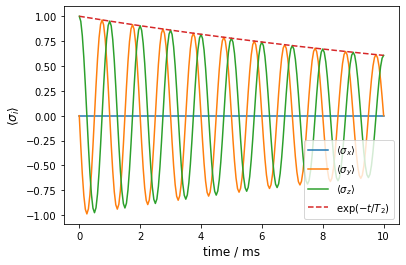

In [4]:
solver_rabi_noise = create_lindblad_solver(
    noise_spectral_density_resonance=0,
    noise_spectral_density_drive=nsd_drive
)

bloch_rabi_noise = evaluate_bloch_components(
    solver_rabi_noise.forward_propagators,
    0, 0, 1                                       
)

times = np.arange(n_time_steps + 1) * total_time / n_time_steps

T2_expected = 2 / (nsd_drive * 0.5)
decay_envelope = np.exp(-times / T2_expected)


plt.plot(times, bloch_rabi_noise[:,0], label="$\langle \sigma_x \\rangle$")
plt.plot(times, bloch_rabi_noise[:,1], label="$\langle \sigma_y \\rangle$")
plt.plot(times, bloch_rabi_noise[:,2], label="$\langle \sigma_z \\rangle$")
plt.plot(times, decay_envelope, linestyle="--", label="$\exp(-t/T_2)$")
plt.ylabel("$\langle \sigma_i \\rangle$", fontsize=12)
plt.xlabel("time / ms", fontsize=12)
plt.legend()

We recognize the expected behaviour and also see that it is qualitatively
different from the case of quasi-static noise.

### Noise on Resonace Frequency
For this particular case, the Bloch vector components will evolve according to

\begin{align}
r_x(t) &= r_x(0) e^{-\frac{\gamma t}{2}} \\
r_y(t) &= e^{-\gamma t / 4} \left(r_y(0) \cos(u_x t) - \left(r_z(0) +
\frac{\gamma}{4 u_x} r_y(0) \right) \sin(u_x  t) \right) \\
r_z(t) &= e^{-\gamma t / 4} \left( r_z(0) \cos(u_x t) + \left(r_y(0) +
\frac{\gamma}{4 u_x} r_z(0) \right) \sin(u_x t)\right)
\end{align}

neglecting quadratic orders in $\frac{\gamma}{4 u_s}$.

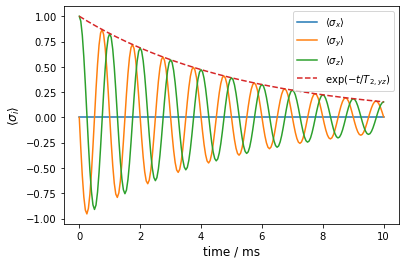

In [5]:
solver_resonance_noise = create_lindblad_solver(
    noise_spectral_density_resonance=nsd_resonance,
    noise_spectral_density_drive=0
)

bloch_resonance_noise = evaluate_bloch_components(
    solver_resonance_noise.forward_propagators,
    0, 0, 1                                       
)

times = np.arange(n_time_steps + 1) * total_time / n_time_steps

T2_expected_yz = 4 / (nsd_resonance * 0.5)

decay_envelope_yz = np.exp(-times / T2_expected_yz)


plt.plot(times, bloch_resonance_noise[:,0],
         label="$\langle \sigma_x \\rangle$")
plt.plot(times, bloch_resonance_noise[:,1],
         label="$\langle \sigma_y \\rangle$")
plt.plot(times, bloch_resonance_noise[:,2],
         label="$\langle \sigma_z \\rangle$")
plt.plot(times, decay_envelope_yz, linestyle="--",
         label="$\exp(-t/T_{2,yz})$")
plt.ylabel("$\langle \sigma_i \\rangle$", fontsize=12)
plt.xlabel("time / ms", fontsize=12)
plt.legend()

Again, we have an exponential decay which is qualitatively different from the
quasi-static pendant. Generally, exponential decays of probability amplitudes
are an inherent property of the Lindblad master equation due to the assumption
of Markovian processes that govern the dissipative part of the evoulution
(c.f., these [lecture notes](https://arxiv.org/abs/1902.00967)).